# Membros da Equipe

- Gabriel Telles Missailidis

- João Lucas Rocha Rolim

- Samir Nunes da Silva

#### Obs: a seguir, há classes e funções definidas para a resolução do projeto. Os tópicos começam após esses códigos, com 1. Análise Descritiva dos Dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC
from logging import getLogger
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)

In [7]:
class Config:
    DATA_FOLDER = f"../data"
    ANALYSIS_FOLDER = f"../analysis"
    TRAIN_FILE = "train.csv"
    TEST_FILE = "test.csv"
    FEATURES_SUBSETS = {
        "fcth": "FCTH",
        "hara": "Haralick",
        "mome": "Moments",
        "ohist": "OpponentHistogram",
        "tamu": "Tamura",
    }


class BaseWrapper(ABC):
    TARGET = "Class"
    
    def __init__(self, class_name):
        self.config = Config()
        self.logger = getLogger(class_name)

    def _map_features_subset(self, features_subset: str):
        if features_subset in self.config.FEATURES_SUBSETS.values():
            return features_subset
        if features_subset in self.config.FEATURES_SUBSETS.keys():
            return self.config.FEATURES_SUBSETS[features_subset]
        self.logger.exception(
            f"features_subset must be in {self.config.FEATURES_SUBSETS.values()} or {self.config.FEATURES_SUBSETS.keys()}"
        )
        raise ValueError


class DataLoader(BaseWrapper):
    """Wrapper for loading data"""

    def __init__(self):
        super().__init__(__name__)

    def load(self, features_subset: str):
        features_subset = self._map_features_subset(features_subset)
        return self._name_dataframes(
            *self._split_features_labels(
                *self._load_train_test(features_subset)
            ),
            features_subset
        )

    def _load_train_test(
        self, features_subset: str
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        folder = f"{self.config.DATA_FOLDER}/{features_subset}"
        return (
            pd.read_csv(
            f"{folder}/{self.config.TRAIN_FILE}", index_col=[0]
        ), 
            pd.read_csv(
            f"{folder}/{self.config.TEST_FILE}", index_col=[0]
        )
        )

    def _split_features_labels(
        self, train: pd.DataFrame, test: pd.DataFrame
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        X_train, y_train = (
            train.drop(self.TARGET, axis=1), train[self.TARGET]
        )
        X_test, y_test = (
            (test.drop(self.TARGET, axis=1), test[self.TARGET])
            if self.TARGET in test.columns
            else (test, None)
        )

        return X_train, X_test, y_train, y_test

    def _name_dataframes(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
        features_subset: str,
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        dfs = (X_train, X_test, y_train, y_test)
        for df in dfs:
            if df is not None:
                df.attrs["name"] = features_subset
        return dfs
    
class DataAnalyzer(BaseWrapper):
    def __init__(self, X_train, y_train):
        super().__init__(__name__)
        self._data = pd.concat([X_train, y_train], axis=1)
        self._data.attrs["name"] = X_train.attrs["name"]
      
    def __str__(self):
        return str(self._data)
    
    def analyze(self):
        self.data_info()
        self.data_summary()
        if len(self._data.drop(self.TARGET, axis=1).columns) <= 25:
            self.correlogram()
            self.features_histograms()
            self.target_feature_scatterplots()
        
    def data_info(self):
        print(self._data.info(verbose=True))
        
    def data_summary(self):
        print(self._data.describe())
      
    def correlogram(self):
        annot = len(self._data.drop(self.TARGET, axis=1).columns) <= 6
        sns.heatmap(self._data.corr("pearson"), cmap="inferno", annot=annot)
        plt.title(f"{self._data.attrs["name"]} Correlogram", fontsize=22)
        plt.show()
        
    def features_histograms(self):
        feature_cols = self._data.drop(self.TARGET, axis=1).columns
        size = int(np.ceil(np.sqrt(len(feature_cols))))
        fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(20,18))
        for i in range(size):
            for j in range(size):
                col_pos = i * size + j
                if col_pos >= len(feature_cols):
                    break
                feature = feature_cols[col_pos]
                axs[i, j].hist(self._data[feature])
                axs[i, j].set_xlabel(f"{feature} Value", fontsize=10)
                axs[i, j].set_ylabel("Count", fontsize=10)
        plt.suptitle(f"{self._data.attrs["name"]} Features Histograms", fontsize=22)
        plt.show()
        
    def target_feature_scatterplots(self):
        feature_cols = self._data.drop(self.TARGET, axis=1).columns
        size = int(np.ceil(np.sqrt(len(feature_cols))))
        fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(20,18))
        for i in range(size):
            for j in range(size):
                col_pos = i * size + j
                if col_pos >= len(feature_cols):
                    break
                feature = feature_cols[col_pos]
                axs[i, j].scatter(x=self._data[self.TARGET], y=self._data[feature])
                axs[i, j].set_xlabel(f"{feature} Value", fontsize=10)
                axs[i, j].set_ylabel(f"{self.TARGET}", fontsize=10)
        plt.suptitle(f"{self._data.attrs["name"]} Target-Feature Scatterplots", fontsize=22)
        plt.show()

#### Importando os dados

In [8]:
loader = DataLoader()
X_train_fcth, X_test_fcth, y_train_fcth, y_test_fcth = loader.load("fcth")
X_train_hara, X_test_hara, y_train_hara, y_test_hara = loader.load("hara")
X_train_mome, X_test_mome, y_train_mome, y_test_mome = loader.load("mome")
X_train_ohist, X_test_ohist, y_train_ohist, y_test_ohist = loader.load("ohist")
X_train_tamu, X_test_tamu, y_train_tamu, y_test_tamu = loader.load("tamu")

# 1. Análise Descritiva dos Dados

In [9]:
da_fcth = DataAnalyzer(X_train_fcth, y_train_fcth)
da_hara = DataAnalyzer(X_train_hara, y_train_hara)
da_mome = DataAnalyzer(X_train_mome, y_train_mome)
da_ohist = DataAnalyzer(X_train_ohist, y_train_ohist)
da_tamu = DataAnalyzer(X_train_tamu, y_train_tamu)

## 1.1. FCTH

In [10]:
da_fcth.analyze()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 1 to 122
Data columns (total 193 columns):
 #    Column  Dtype
---   ------  -----
 0    V2      int64
 1    V3      int64
 2    V4      int64
 3    V5      int64
 4    V6      int64
 5    V7      int64
 6    V8      int64
 7    V9      int64
 8    V10     int64
 9    V11     int64
 10   V12     int64
 11   V13     int64
 12   V14     int64
 13   V15     int64
 14   V16     int64
 15   V17     int64
 16   V18     int64
 17   V19     int64
 18   V20     int64
 19   V21     int64
 20   V22     int64
 21   V23     int64
 22   V24     int64
 23   V25     int64
 24   V26     int64
 25   V27     int64
 26   V28     int64
 27   V29     int64
 28   V30     int64
 29   V31     int64
 30   V32     int64
 31   V33     int64
 32   V34     int64
 33   V35     int64
 34   V36     int64
 35   V37     int64
 36   V38     int64
 37   V39     int64
 38   V40     int64
 39   V41     int64
 40   V42     int64
 41   V43     int64
 42   V44     int64


## 1.2. Haralick

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 1 to 122
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V2      80 non-null     float64
 1   V3      80 non-null     float64
 2   V4      80 non-null     float64
 3   V5      80 non-null     float64
 4   V6      80 non-null     float64
 5   V7      80 non-null     float64
 6   V8      80 non-null     float64
 7   V9      80 non-null     float64
 8   V10     80 non-null     float64
 9   V11     80 non-null     float64
 10  V12     80 non-null     float64
 11  V13     80 non-null     float64
 12  V14     79 non-null     float64
 13  V15     80 non-null     float64
 14  Class   80 non-null     int64  
dtypes: float64(14), int64(1)
memory usage: 10.0 KB
None
              V2         V3            V4            V5         V6         V7  \
count  80.000000  80.000000     80.000000     80.000000  80.000000  80.000000   
mean    0.197510   7.986650  10165.315756   4616.5039

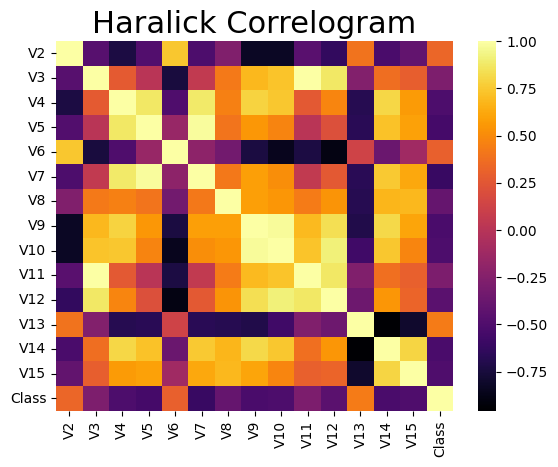

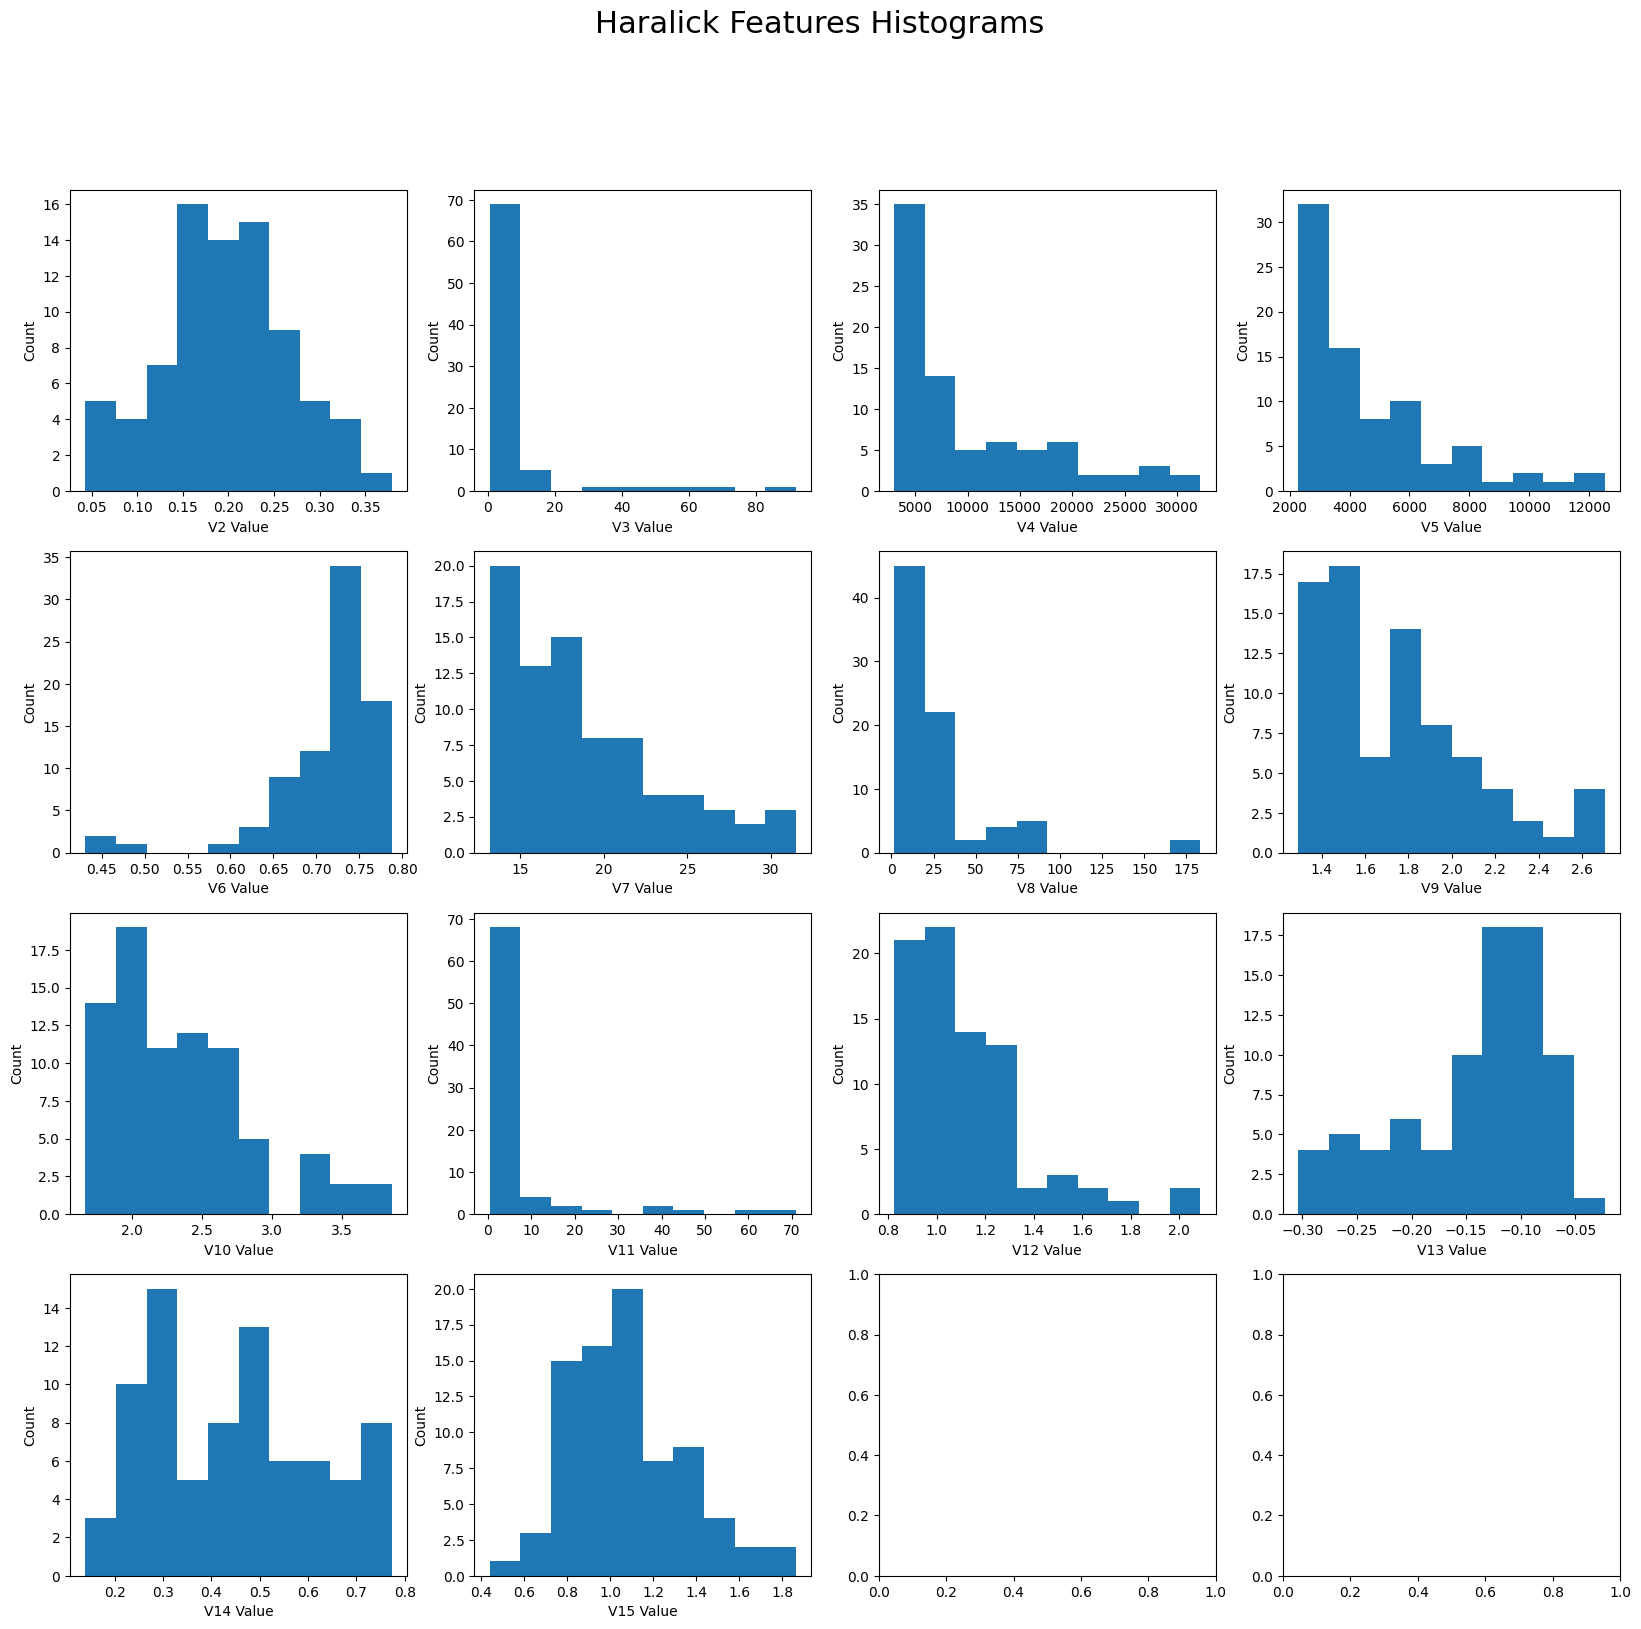

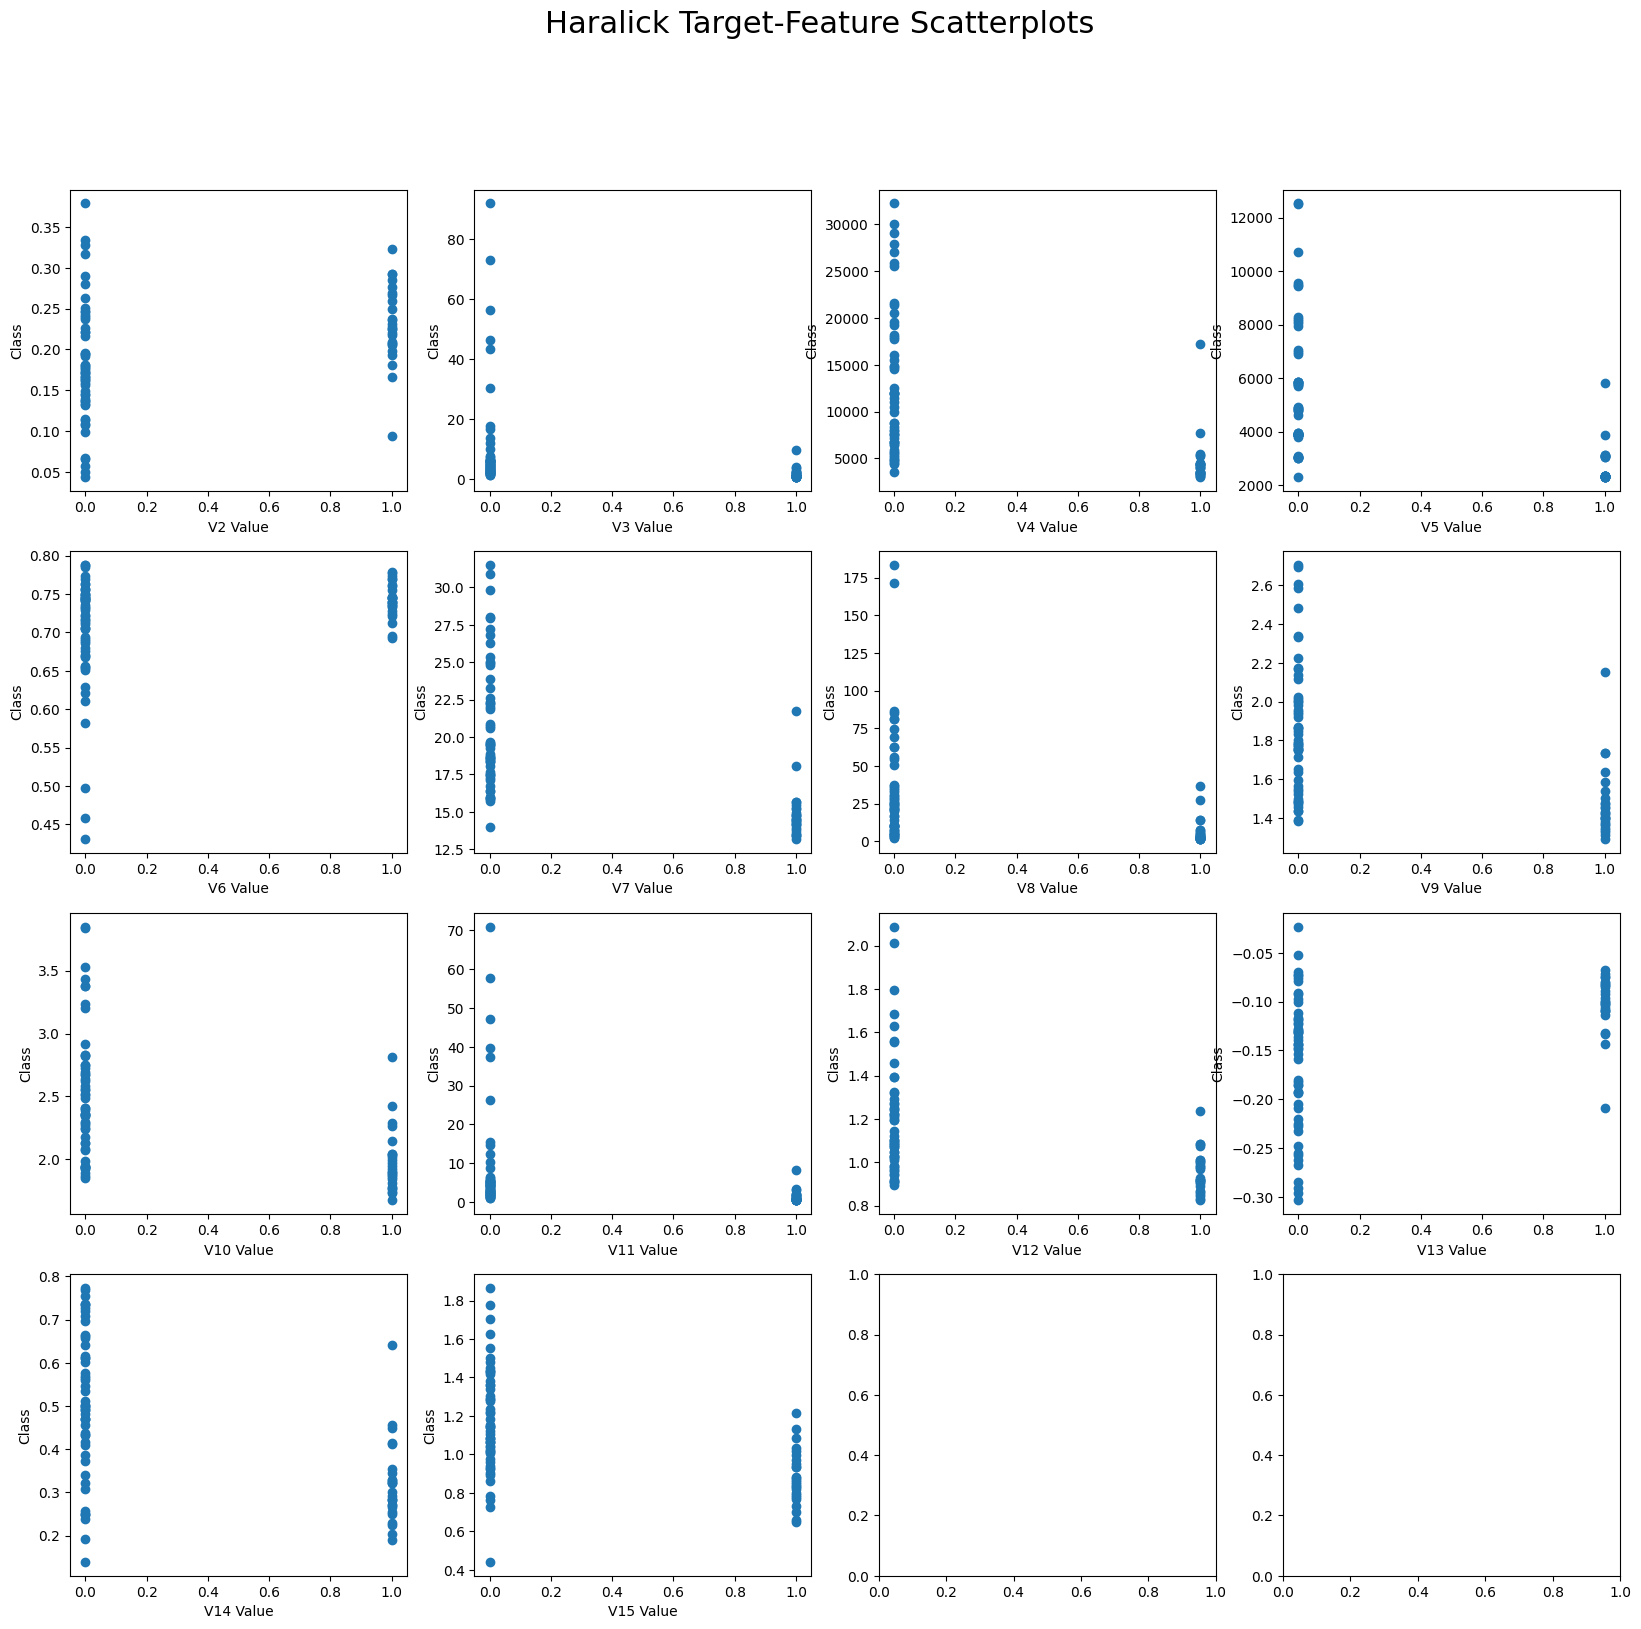

In [26]:
da_hara.analyze()

## 1.3. Moments

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 1 to 122
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V2      80 non-null     float64
 1   V3      80 non-null     float64
 2   V4      80 non-null     float64
 3   V5      80 non-null     float64
 4   Class   80 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 3.8 KB
None
               V2         V3         V4          V5     Class
count   80.000000  80.000000  80.000000   80.000000  80.00000
mean    80.303177  19.381849   5.460810   48.292944   0.32500
std     18.388209  12.707064   2.145295   36.380115   0.47133
min     57.748000   5.068510   0.466932    0.443753   0.00000
25%     65.403527   9.794905   4.066747   22.772620   0.00000
50%     77.039458  15.979428   5.409646   38.495927   0.00000
75%     92.321219  25.423502   7.082335   71.896368   1.00000
max    130.067565  55.491316  10.780591  209.128002   1.00000


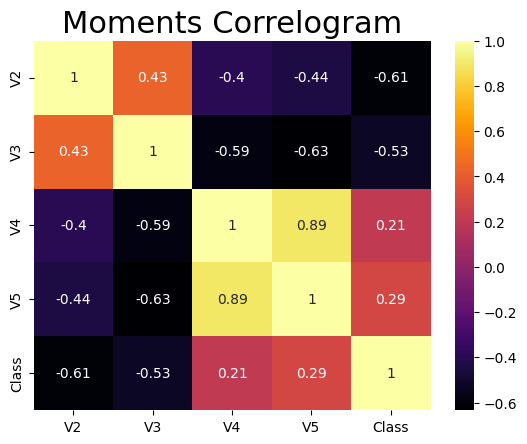

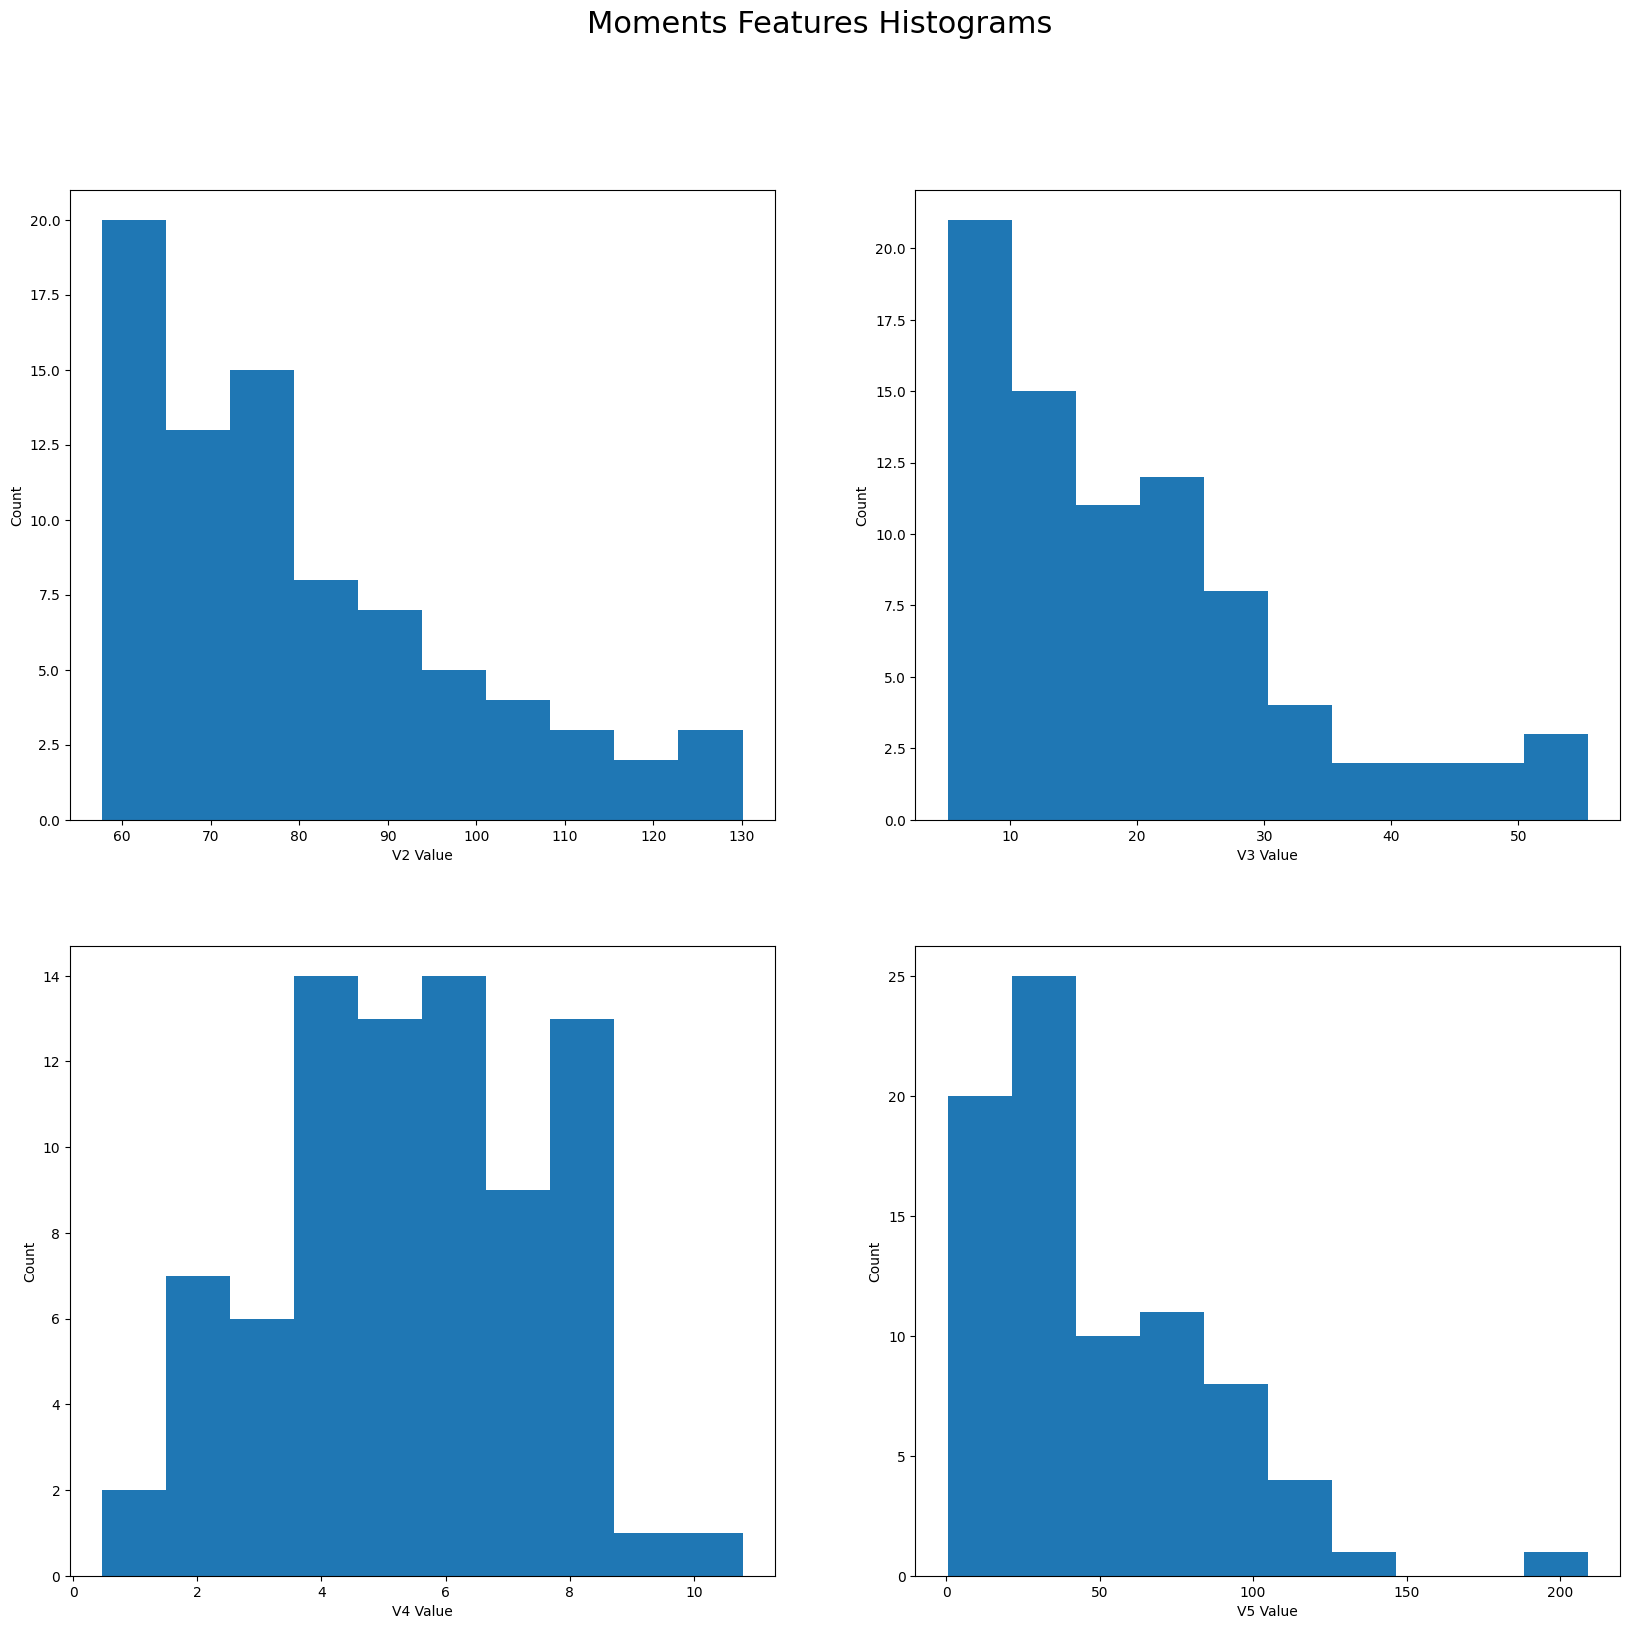

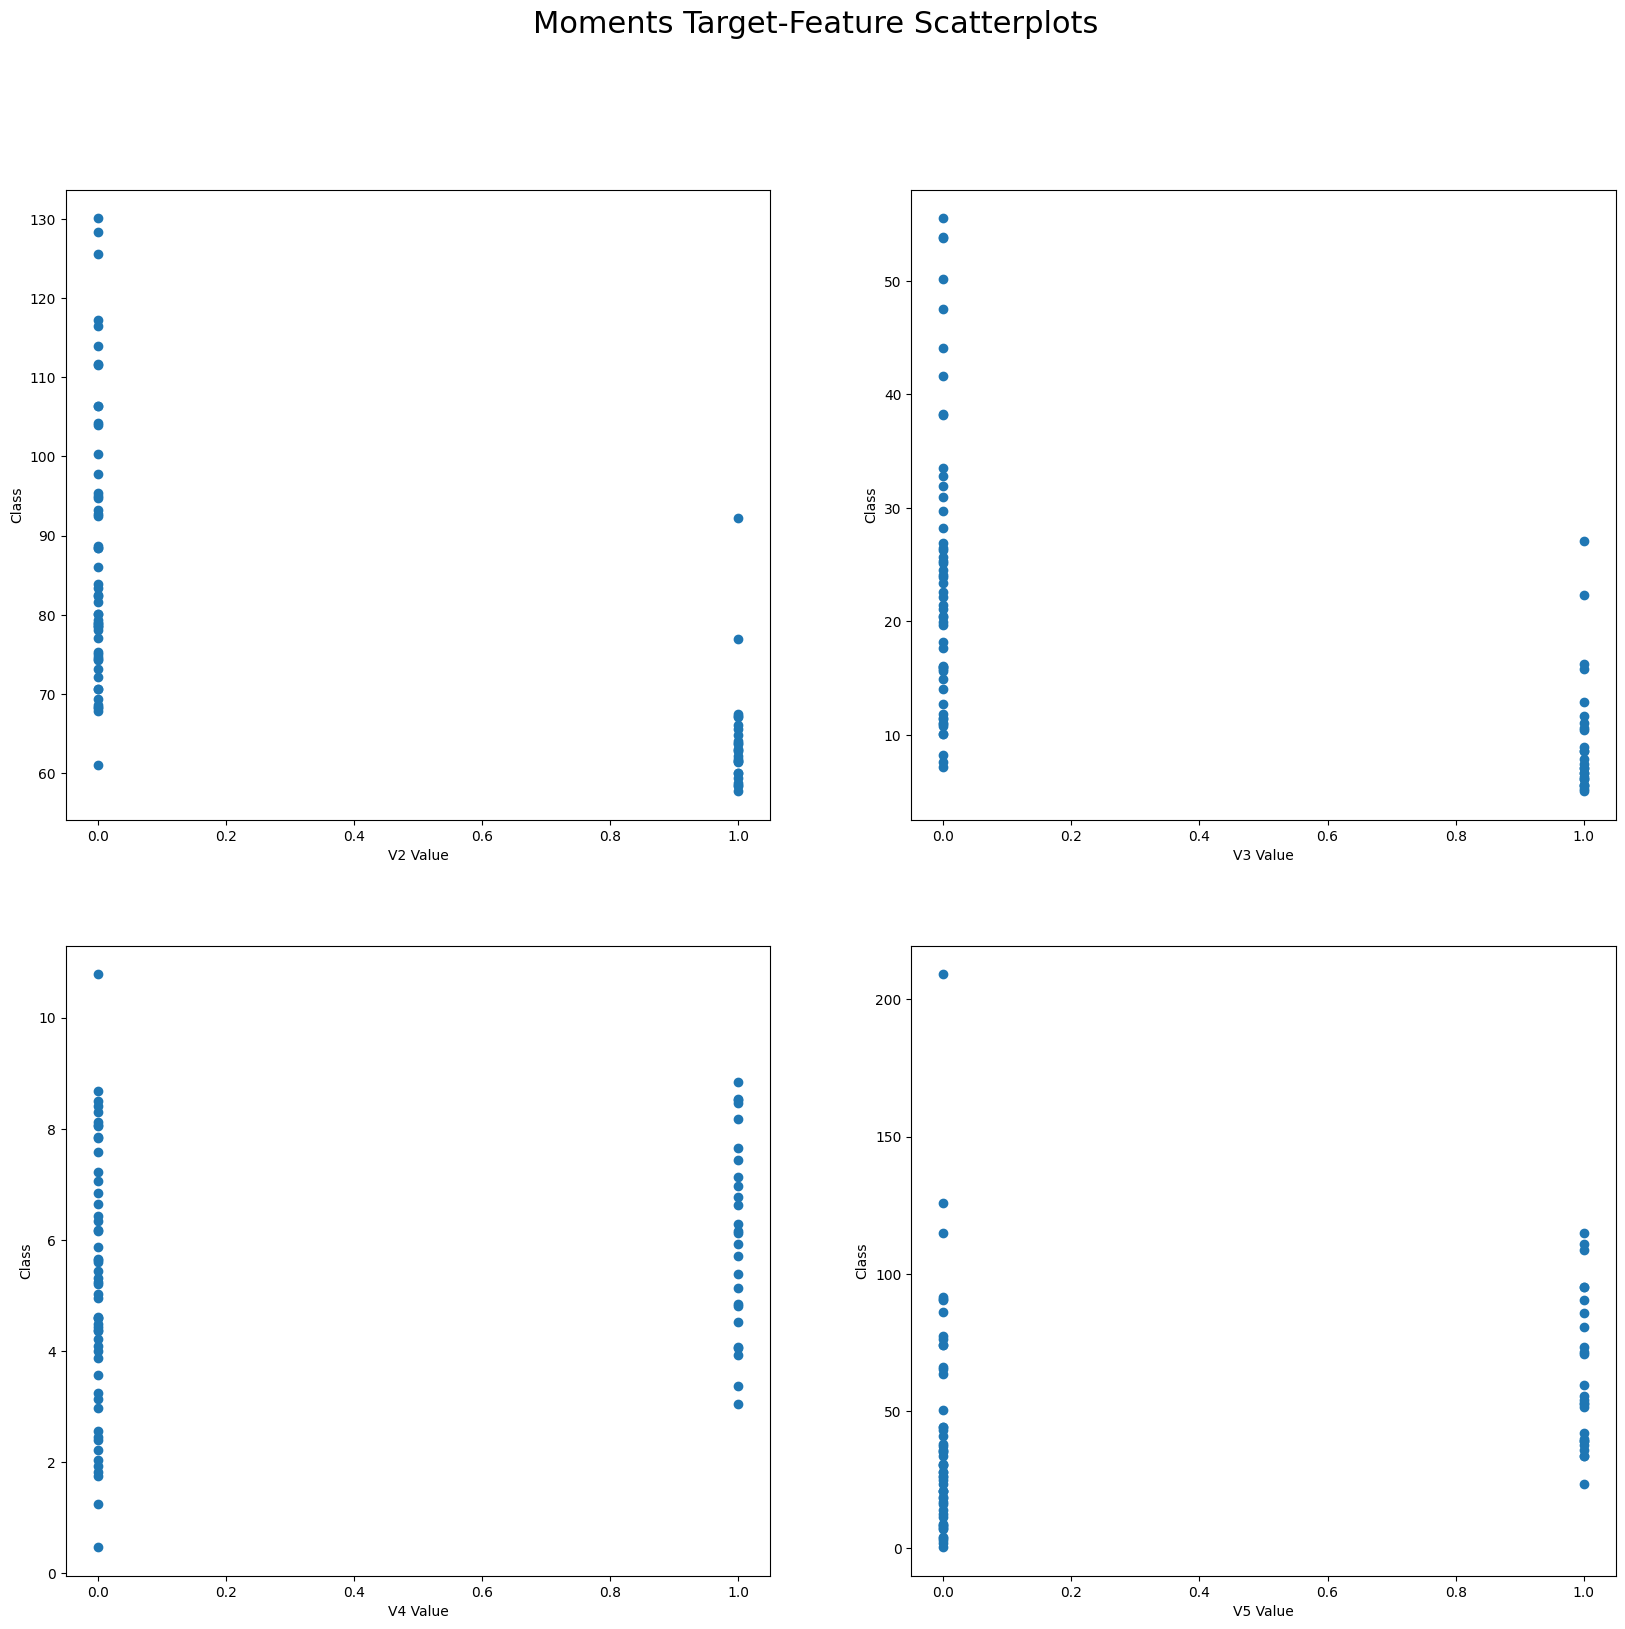

In [27]:
da_mome.analyze()

## 1.4. OpponentHistogram

In [29]:
da_ohist.analyze()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 1 to 122
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V2      80 non-null     int64
 1   V3      80 non-null     int64
 2   V4      80 non-null     int64
 3   V5      80 non-null     int64
 4   V6      80 non-null     int64
 5   V7      80 non-null     int64
 6   V8      80 non-null     int64
 7   V9      80 non-null     int64
 8   V10     80 non-null     int64
 9   V11     80 non-null     int64
 10  V12     80 non-null     int64
 11  V13     80 non-null     int64
 12  V14     80 non-null     int64
 13  V15     80 non-null     int64
 14  V16     80 non-null     int64
 15  V17     80 non-null     int64
 16  V18     80 non-null     int64
 17  V19     80 non-null     int64
 18  V20     80 non-null     int64
 19  V21     80 non-null     int64
 20  V22     80 non-null     int64
 21  V23     80 non-null     int64
 22  V24     80 non-null     int64
 23  V25     80 non-null  

## 1.5. Tamura

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 1 to 122
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V2      80 non-null     float64
 1   V3      80 non-null     float64
 2   V4      80 non-null     int64  
 3   V5      80 non-null     int64  
 4   V6      80 non-null     int64  
 5   V7      80 non-null     int64  
 6   V8      80 non-null     int64  
 7   V9      80 non-null     int64  
 8   V10     80 non-null     int64  
 9   V11     80 non-null     int64  
 10  V12     80 non-null     int64  
 11  V13     80 non-null     int64  
 12  V14     80 non-null     int64  
 13  V15     80 non-null     int64  
 14  V16     80 non-null     int64  
 15  V17     80 non-null     int64  
 16  V18     80 non-null     int64  
 17  V19     80 non-null     int64  
 18  Class   80 non-null     int64  
dtypes: float64(2), int64(17)
memory usage: 12.5 KB
None
              V2         V3          V4         V5          V6     

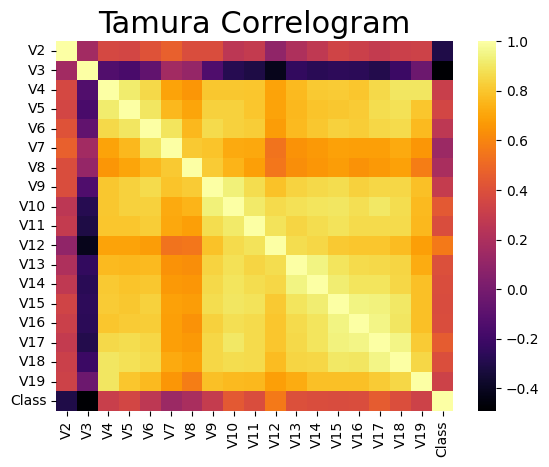

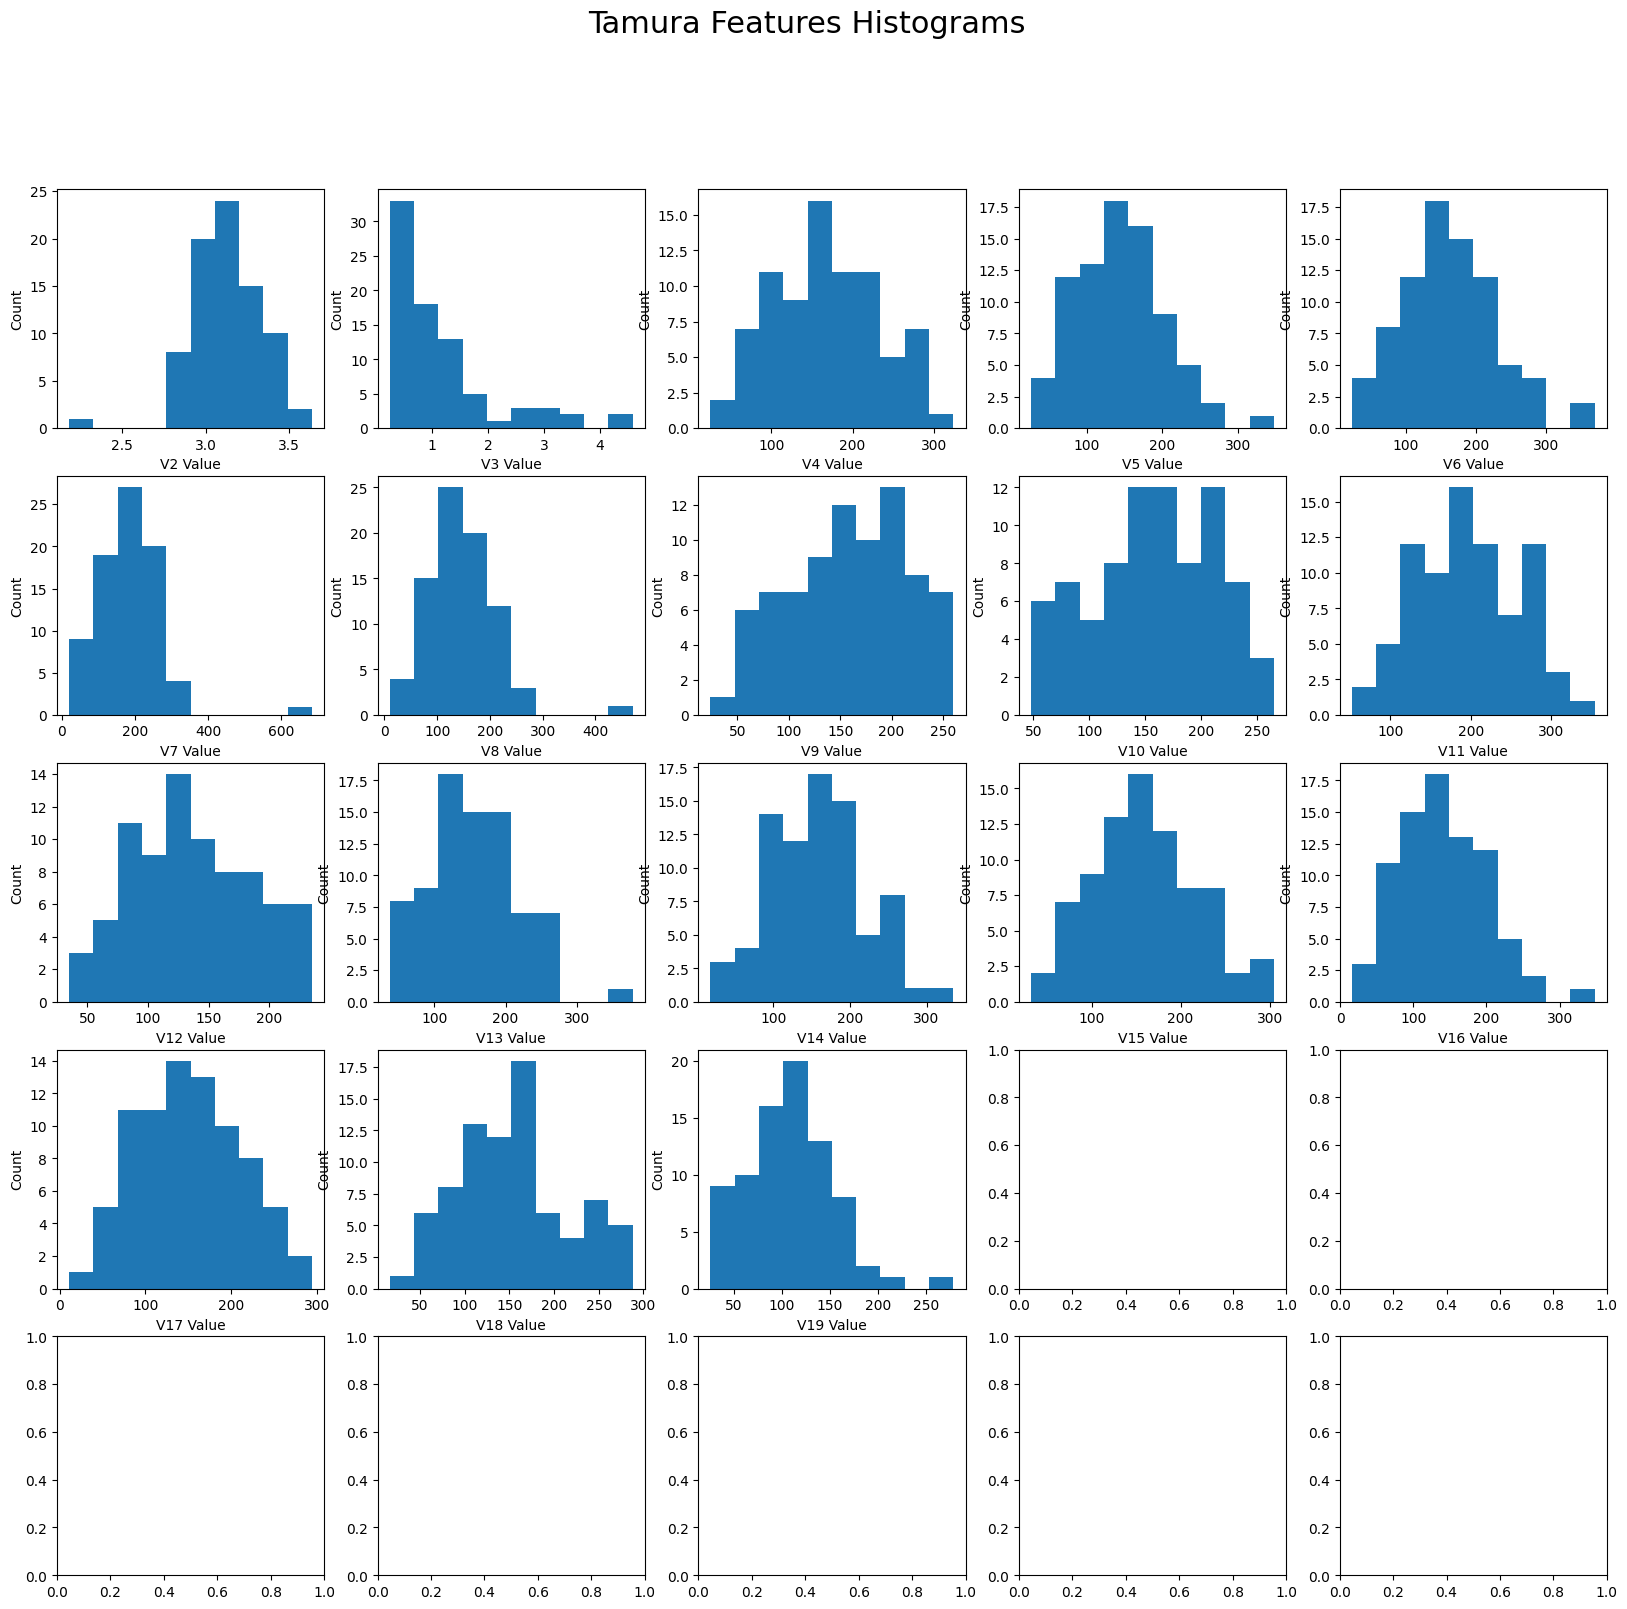

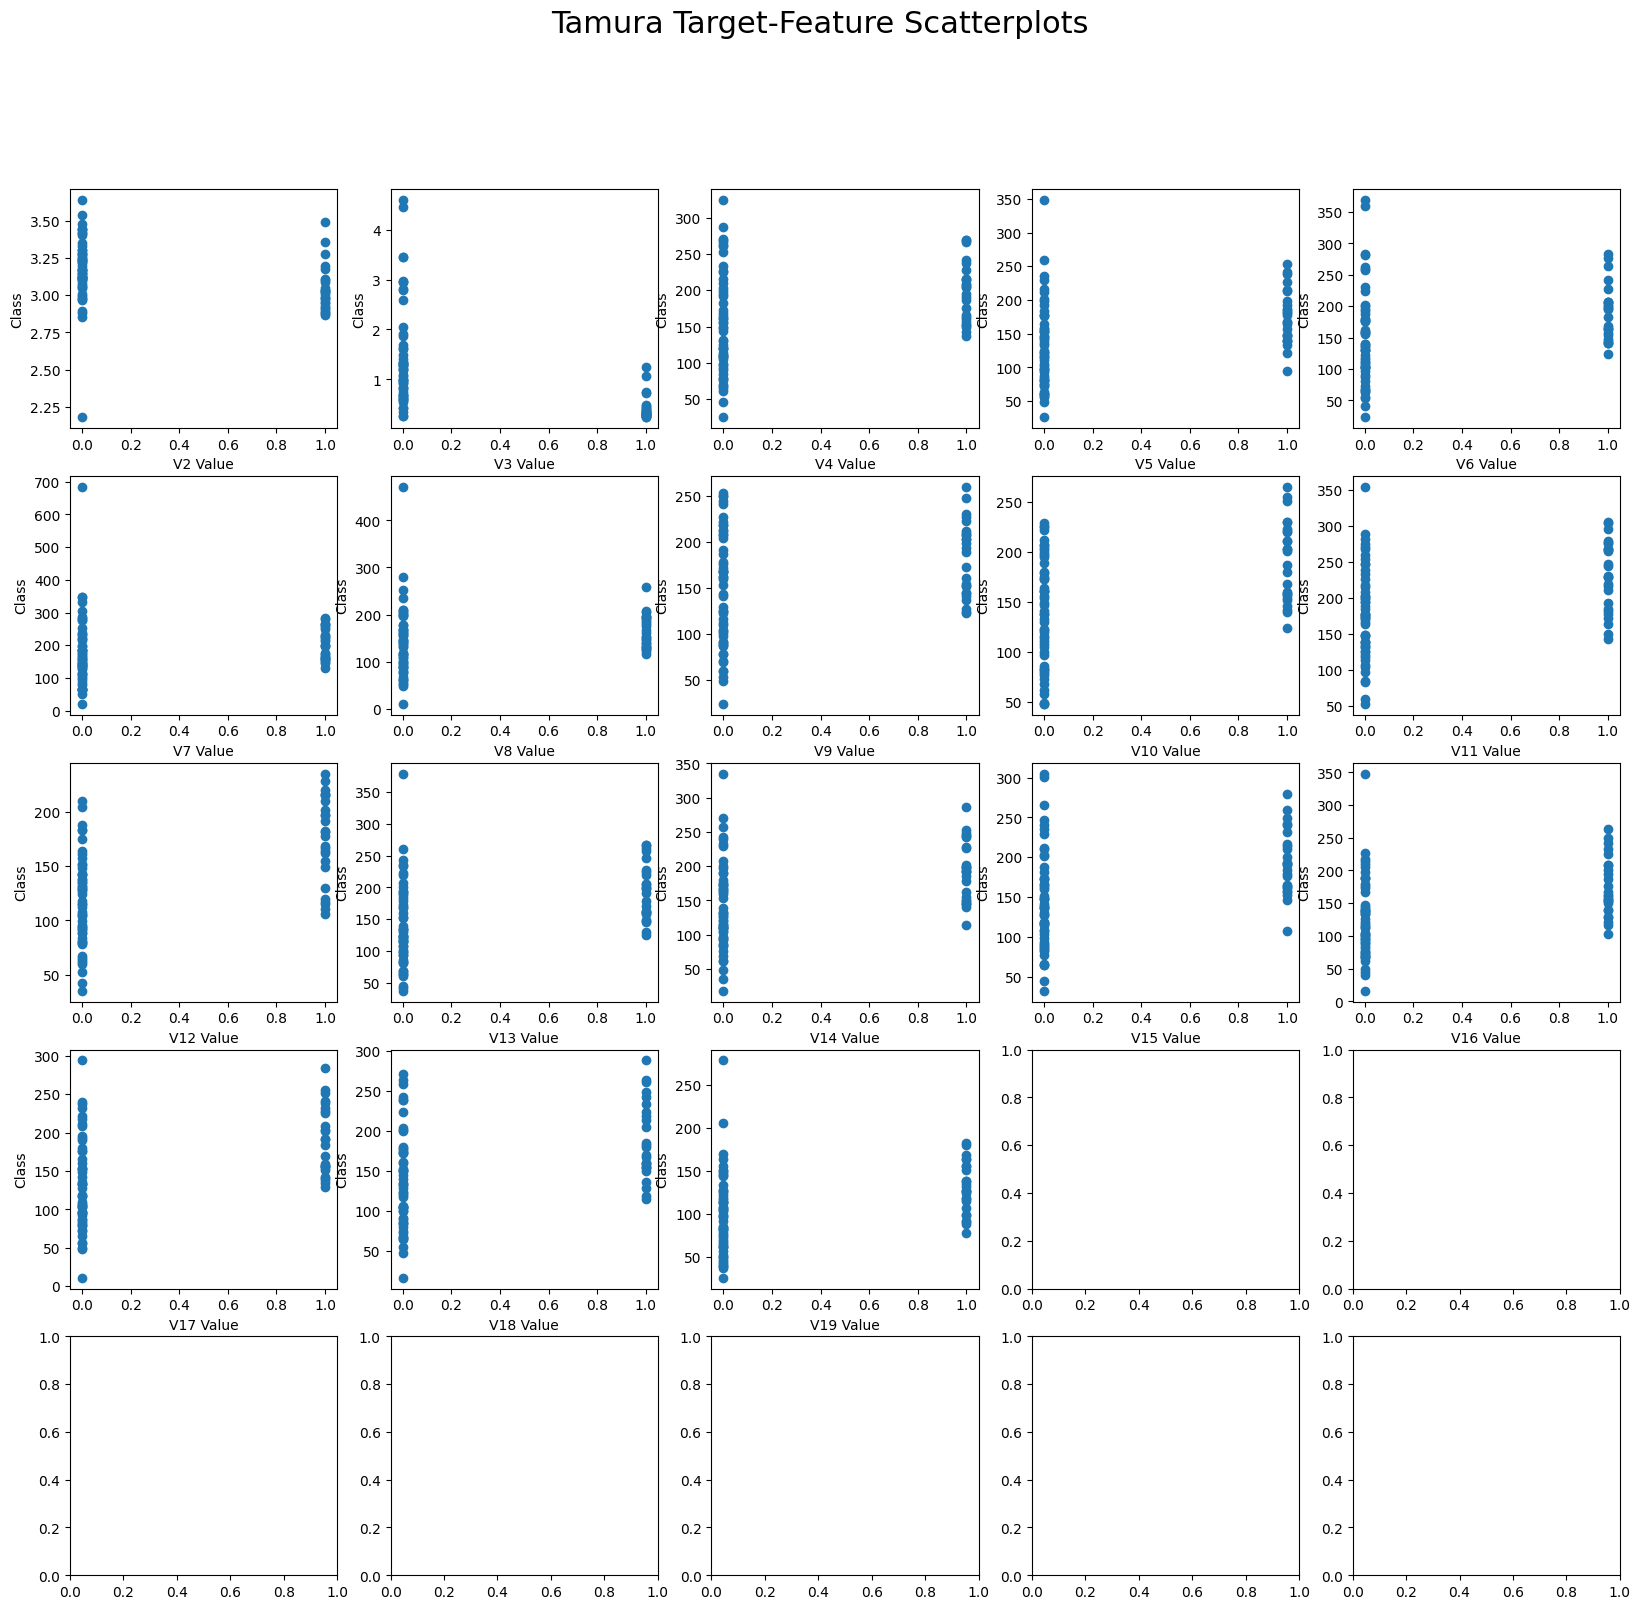

In [30]:
da_tamu.analyze()

# 2. Resultados da Validação Cruzada

# 3. Resultados em Conjunto de Teste Independente

# 4. Discussões

# 5. Conclusões: Comentários e sugestões sobre o trabalho